In [1]:
import os
import sys
import importlib
import numpy as np
script_dir = '/mnt/c/Users/kevin/OneDrive/2-code/1-Research_projects/1-project-categorical-MMN/notebooks'
src_dir = os.path.join(script_dir, '..', 'src')
sys.path.append(src_dir)
import parameters as params
import classes as cl
import basic_functions as bf
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
params.PARAMS_Stimulus['type'] = "multi_control_paradigm"
params.PARAMS_Stimulus['list_std'] = [25,50,75,100,125]
params.PARAMS_Simulation['t_total'] = 20.0
params.PARAMS_Integrator['tau'] = 0.4
params.PARAMS_PC['gA'] = -0.01
params.PARAMS_SST['gA'] = -0.01

params.PARAMS_Synapses_Integrator['wmax'] = 2.0*0.15/20


stim = cl.Stimulus(params.PARAMS_Stimulus, params.PARAMS_Simulation, params.PARAMS_PC['Ncells'])

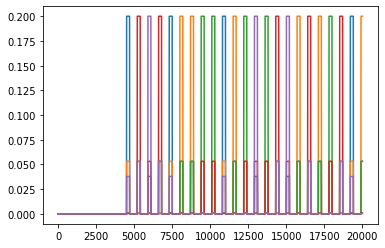

In [3]:

plt.plot(stim.stimulus[params.PARAMS_Stimulus['list_std'],:].transpose())
# plt.plot(stim.stimulus[88,:])

In [49]:
my_network = cl.Network(params.PARAMS_Integrator, params.PARAMS_Synapses_Integrator, params.PARAMS_PC, params.PARAMS_PV, params.PARAMS_SST, params.PARAMS_VIP, params.PARAMS_NDF, params.PARAMS_Simulation, params.PARAMS_Stimulus)
my_network.full_dynamics(stim.stimulus)

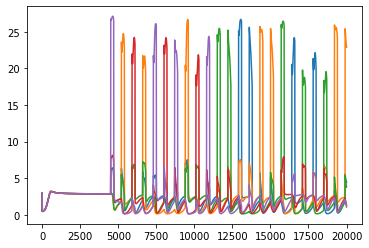

In [50]:
plt.plot(my_network.save_pc_layer[params.PARAMS_Stimulus['list_std'],:].transpose())

In [51]:
params.PARAMS_SST['gA'] = -0.001
params.PARAMS_PC['gA'] = -0.001

my_network2 = cl.Network(params.PARAMS_Integrator, params.PARAMS_Synapses_Integrator, params.PARAMS_PC, params.PARAMS_PV, params.PARAMS_SST, params.PARAMS_VIP, params.PARAMS_NDF, params.PARAMS_Simulation, params.PARAMS_Stimulus)

my_network2.full_dynamics(stim.stimulus)

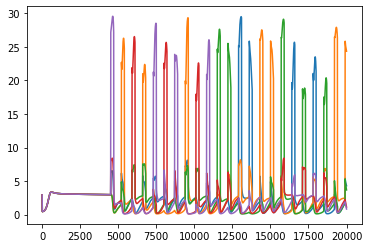

In [52]:
plt.plot(my_network2.save_pc_layer[params.PARAMS_Stimulus['list_std'],:].transpose())

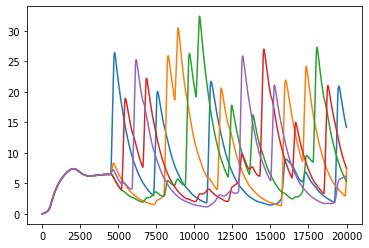

In [6]:
plt.plot(my_network.save_integrator_layer[params.PARAMS_Stimulus['list_std'],:].transpose())

there seems to be a prediciton index. However simulaitons are needed to confirm and to find what's the main driver of this effect.

It seems that the strength of integrator feedback seems to be responsible for the prediciton index.

To understand how to compute the different quantities for the prediciton, let's write some useful functions:

In [7]:
# function that computes the mean firing rates of the cells upon presentation of a stimulus
def compute_mean_firing_rate(network,stim = None):
    ''' '''
    if network.PARAMS_Stimulus['type'] not in ['multi_control_paradigm','probabilistic_MMN']:
        raise ValueError('The function compute_mean_firing_rate is only defined for multi_control_paradigm')
    elif network.PARAMS_Stimulus['type'] == 'multi_control_paradigm':
        temp = bf.compute_list_time_input(network.PARAMS_Simulation['dt'],network.PARAMS_Simulation['t_total'], network.PARAMS_Stimulus['Tinter'], network.PARAMS_Stimulus['Tresting'], network.PARAMS_Stimulus['Tstim'])
        
        mean_temp = np.zeros(len(temp))
        for i in range(len(temp)):
            mean_temp[i] = np.max(network.save_pc_layer[:,temp[i]])
        
        return np.mean(mean_temp)
    
    elif network.PARAMS_Stimulus['type'] == 'probabilistic_MMN':
        std_id = network.PARAMS_Stimulus['std_id']
        dev_id = network.PARAMS_Stimulus['dev_id']
        
        temp = bf.compute_list_time_input(network.PARAMS_Simulation['dt'],network.PARAMS_Simulation['t_total'], network.PARAMS_Stimulus['Tinter'], network.PARAMS_Stimulus['Tresting'], network.PARAMS_Stimulus['Tstim'])
        
        is_std = [i for i in range(len(temp)) if np.argmax(network.save_pc_layer[:,temp[i]]) == std_id]
        is_dev = [i for i in range(len(temp)) if np.argmax(network.save_pc_layer[:,temp[i]]) == dev_id]
        
        mean_temp_std = np.zeros(len(is_std))
        mean_temp_dev = np.zeros(len(is_dev))
        for i in range(len(is_std)):
            mean_temp_std[i] = np.max(network.save_pc_layer[:,temp[is_std[i]]])
            
        for i in range(len(is_dev)):
            mean_temp_dev[i] = np.max(network.save_pc_layer[:,temp[is_dev[i]]])
            
        return np.mean(mean_temp_std), np.mean(mean_temp_dev)
        
        
        
        
        
        

In [8]:
mean_list = compute_mean_firing_rate(my_network)

IndexError: index 20000 is out of bounds for axis 1 with size 20000

In [ ]:
mean_list

19.245726632647756

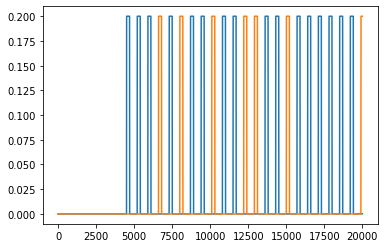

In [ ]:
params.PARAMS_Stimulus['type'] = 'probabilistic_MMN'
params.PARAMS_Stimulus['prob_std'] = 0.8


stim = cl.Stimulus(params.PARAMS_Stimulus, params.PARAMS_Simulation, params.PARAMS_PC['Ncells'])

plt.plot(stim.stimulus[20,:])
plt.plot(stim.stimulus[88,:])


In [ ]:
my_network.full_dynamics(stim.stimulus)

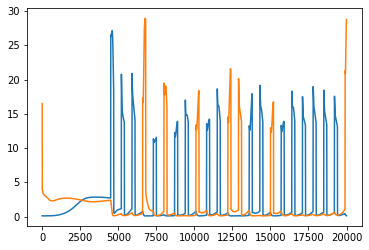

In [ ]:
plt.plot(my_network.save_pc_layer[20,:])
plt.plot(my_network.save_pc_layer[88,:])

In [ ]:
a,b = compute_mean_firing_rate(my_network,stim)

In [ ]:
a


14.993853697786678

a first exploratory amalysis seems to show that adaptation corresponds indeed to an adaptatoin index. And top-down indeed to a prediciton index.

In [80]:
data_dir = os.path.join(script_dir,'..', 'data/sims/script2') 
d = 58
delay=50
file_dir = os.path.join(data_dir, 'script2_delay_'+str(delay)+'mean_firing_rates_dev_id'+str(d)+'.json')
import json
index_88 = json.load(open(file_dir))

Text(0.5, 1.0, 'FIring rate in the multi-control paradigm Tinter 0.5 s')

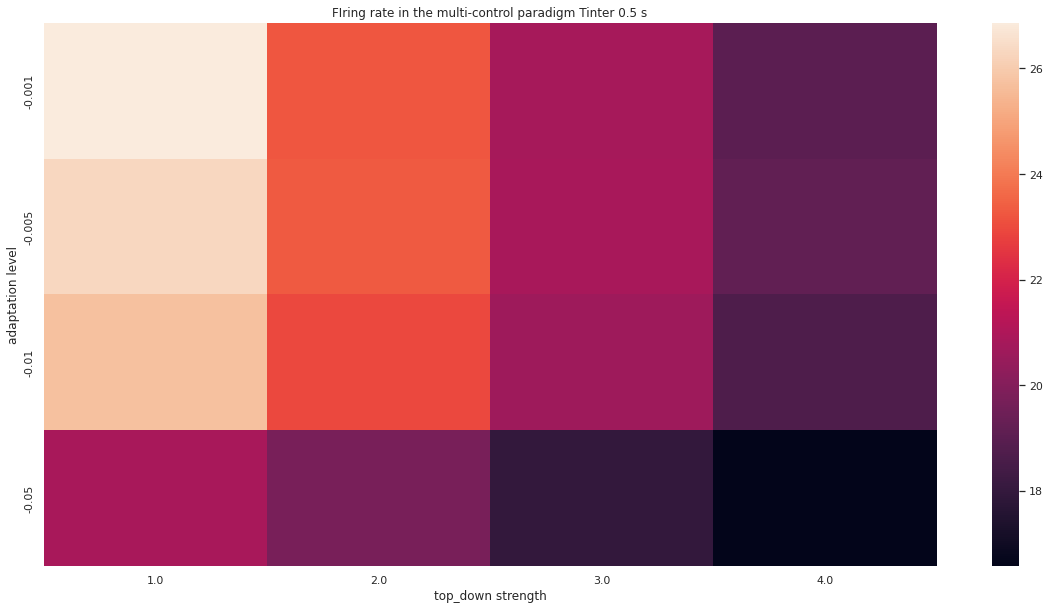

In [91]:
import matplotlib as mpl

adaptation_list = [-0.001, -0.005, -0.01, -0.05]
top_down_feedback_list = [1.0, 2.0, 3.0, 4.0]
Tinter_list = [0.2, 0.5,0.7,1.0,1.5,2.0]
idx_tinter = 1
sns.set_theme(style="darkgrid")
mpl.rcParams['figure.figsize'] = (20, 10)

multi_control = np.array( index_88['multi_control'])
sns.heatmap(multi_control[:,:,idx_tinter], yticklabels = list(map(str,adaptation_list)), xticklabels = list(map(str,top_down_feedback_list)))
plt.xlabel('top_down strength')
plt.ylabel('adaptation level')
plt.title('FIring rate in the multi-control paradigm Tinter '+ str(Tinter_list[idx_tinter])+' s')

Text(0.5, 1.0, 'MMN effect Tinter 0.5 s')

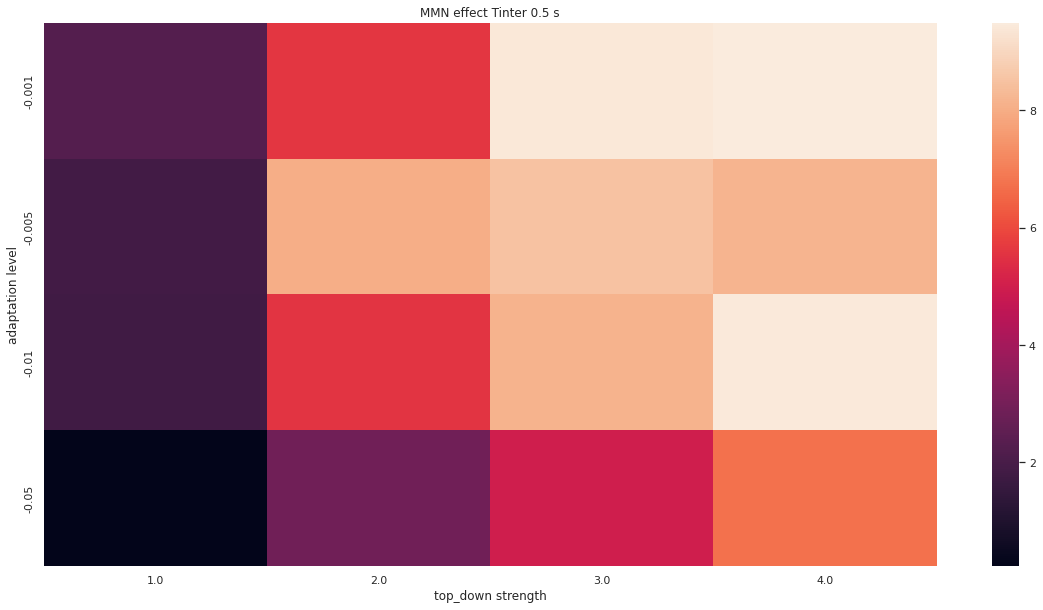

In [92]:
saving_proba_control = np.array(index_88['proba_control'])
saving_proba_dev = np.array(index_88['proba_dev'])

sns.heatmap(saving_proba_dev[:,:,1] - saving_proba_control[:,:,1], yticklabels = list(map(str,adaptation_list)), xticklabels = list(map(str,top_down_feedback_list)))
plt.xlabel('top_down strength')
plt.ylabel('adaptation level')
plt.title('MMN effect Tinter '+ str(Tinter_list[idx_tinter])+' s')



Text(0.5, 1.0, 'Adaptation index Tinter 0.5 s')

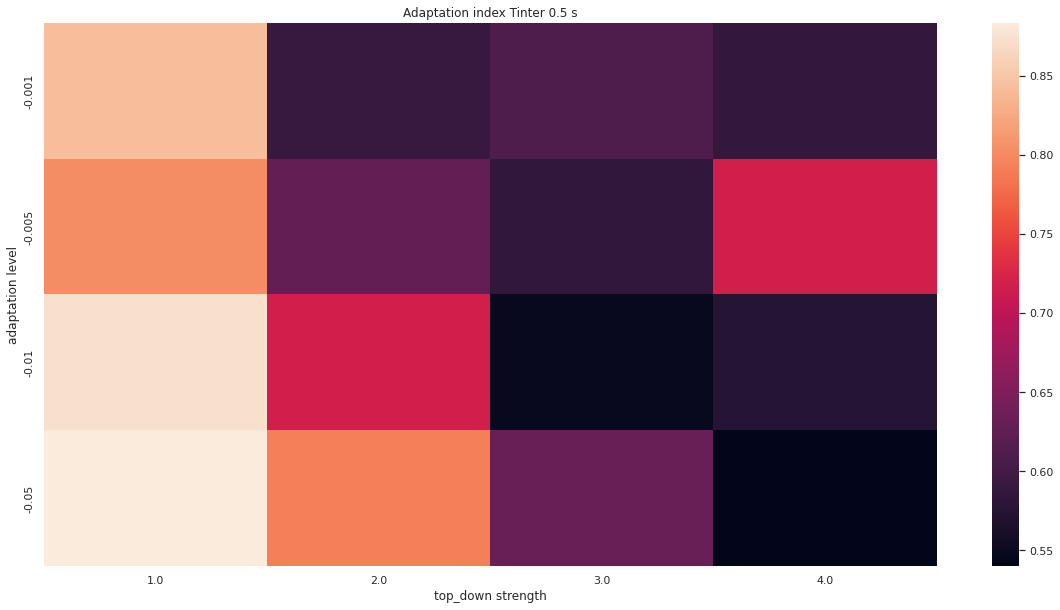

In [93]:

sns.heatmap(-(saving_proba_control[:,:,1] - multi_control[:,:,1])/(saving_proba_dev[:,:,1] - saving_proba_control[:,:,1]), yticklabels = list(map(str,adaptation_list)), xticklabels = list(map(str,top_down_feedback_list)))
plt.xlabel('top_down strength')
plt.ylabel('adaptation level')
plt.title('Adaptation index Tinter '+ str(Tinter_list[idx_tinter])+' s')


Text(0.5, 1.0, 'Prediction index Tinter 0.5 s')

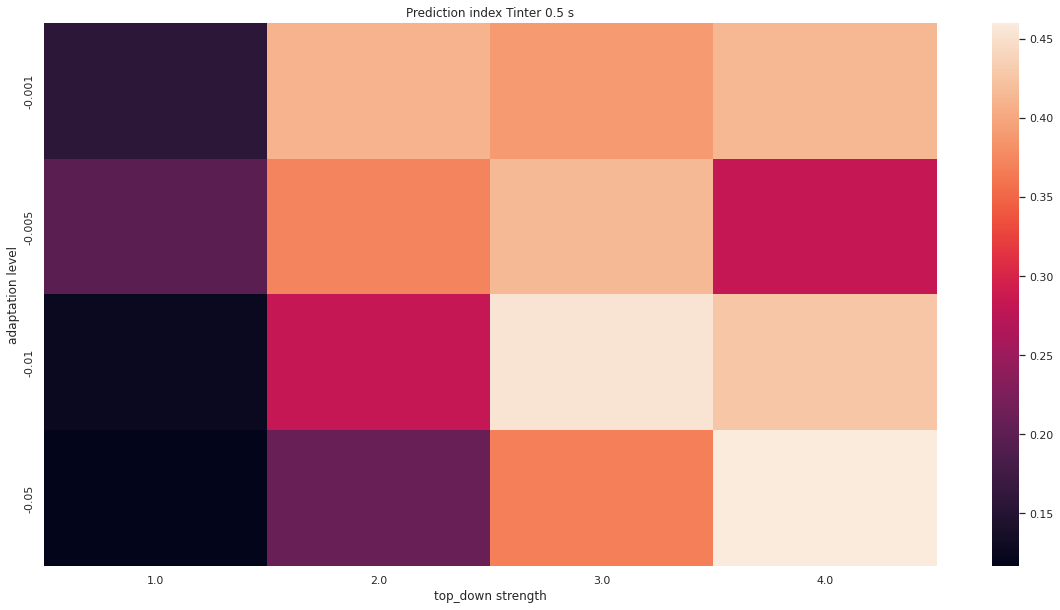

In [94]:

sns.heatmap((saving_proba_dev[:,:,1] - multi_control[:,:,1])/(saving_proba_dev[:,:,1] - saving_proba_control[:,:,1]), yticklabels = list(map(str,adaptation_list)), xticklabels = list(map(str,top_down_feedback_list)))
plt.xlabel('top_down strength')
plt.ylabel('adaptation level')
plt.title('Prediction index Tinter '+ str(Tinter_list[idx_tinter])+' s')